# **Hidding the network jitter**

## **Contenido**

1. Caracterización de la latencia en diferentes escenarios
    - En tu ordenador
    - En Internet
2. Clasificación de QoE
   - En tu host
   - En Internet
   - En tu host, pero simulando Internet
3. Clasificación QoE considerando perdida de paquetes
4. Control del tamaño del Buffer en InterCom
5. Creación del modulo NAT_Traversal

## **Caracterización de la latencia en diferentes escenarios:**

### **En tu ordenador:**

1. **Ping a localhost**

In [ ]:
!ping localhost -c 1000 -s 4096 > /tmp/ping.txt

^C


2. **Almacenasmos las latencias en localhost_latencies.txt**

In [ ]:
%%bash
export LC\_NUMERIC=en\_US.UTF-8 # Use "." instead of "," for the decimal separator
grep from < /tmp/ping.txt | cut -f 4 -d "=" | cut -f 1 -d " " | awk '{print $1/2}' > /tmp/localhost_latencies.txt

3. **Encontramos el histograma relacionado con las latencias esperadas**

In [ ]:
import numpy as np
from scipy import stats
latencies = np.loadtxt("/tmp/localhost_latencies.txt")
average_latency = np.average(latencies)
print("\naverage latency =", average_latency)
max_latency = np.max(latencies)
min_latency = np.min(latencies)
maximum_absolute_deviation = max(max_latency - average_latency, average_latency - min_latency)
print("maximum absolute deviation (jitter) =", maximum_absolute_deviation)
correlation_coefficient = stats.pearsonr(latencies, np.roll(latencies, 1))[0]
print("Pearson correlation coefficient =", correlation_coefficient)
if correlation_coefficient < 0:
  print("Correlation coefficient < 0: use 0 (no correlation between RTT samples) in your experiments")
histogram = np.histogram(latencies)
np.savetxt("/tmp/localhost_histogram.txt", histogram[0])


average latency = 0.022076500000000002
maximum absolute deviation (jitter) = 0.014576500000000003
Pearson correlation coefficient = 0.03235524302902394


**El resultado obtenido ha sido:**

average latency = 0.021672672672672668

maximum absolute deviation (jitter) = 0.017827327327327332

Pearson correlation coefficient = 0.16497126018732858

4. **Trazamos el histograma**

In [ ]:
!pip install gnuplot_kernel

In [ ]:
%reload_ext gnuplot_kernel

In [ ]:
%%gnuplot
set terminal pngcairo


Terminal type is now 'pngcairo'
Options are ' background "#ffffff" enhanced fontscale 1.0 size 385, 256 '

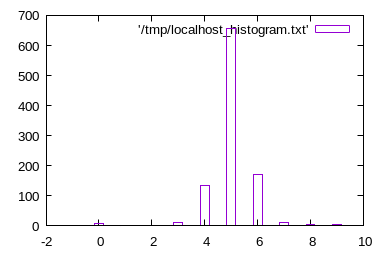

In [ ]:
%%gnuplot
plot '/tmp/localhost_histogram.txt' with histogram

5. **Caracterización de la latencia**

Según el grafico obtenido, podemos determinar que se trata de una distribución normal.

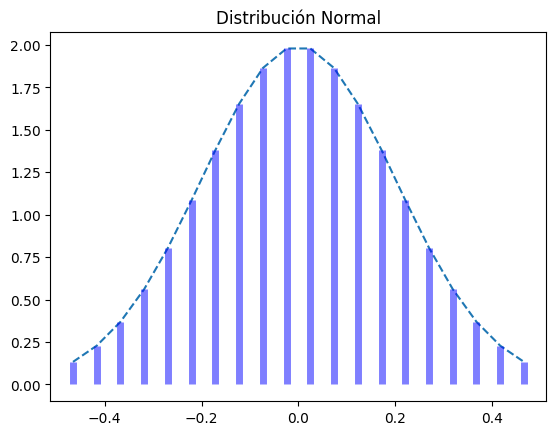

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Graficando Distrobución Normal
mu, sigma = 0, 0.2 # media y desvio estandar
normal = stats.norm(mu, sigma)
x = np.linspace(normal.ppf(0.01),
                normal.ppf(0.99),20)
fp = normal.pdf(x) # Función de Probabilidad
plt.plot(x, fp, '--')
plt.vlines(x, 0, fp, colors='b', lw=5, alpha=0.5)
plt.title('Distribución Normal')
plt.show()

### **En Internet:**

Repetimos el experimento anterior para obtener la sumatoria de latencias desde tu PC hasta la IP privada de tu NAT y desde el pc de tu compañero a la IP publica de tu NAT.

1. **Obtenemos la IP publica del NAT**

In [ ]:
!curl ipecho.net/plain

217.216.183.232

2. **Nuestro compañero nos da la IP publica de su router y ejecutamos el siguiente comando para obtener latencias**

In [ ]:
!ping 85.60.199.122 -c 1000 -s 4096 > /tmp/85.60.199.122_latencies.txt

3. **Obtenemos las latencias de nuestro PC hacia nuestro NAT usando su IP privada**

In [ ]:
!ping 192.168.0.1 -c 1000 -s 4096 > /tmp/192.168.0.1_latencies.txt

4. **Almacenamos las latencias**

In [ ]:
%%bash
export LC\_NUMERIC=en\_US.UTF-8 # Use "." instead of "," for the decimal separator
grep from < /tmp/85.60.199.122_latencies.txt | cut -f 4 -d "=" | cut -f 1 -d " " | awk '{print $1/2}' > /tmp/pubip_latencies.txt

In [ ]:
%%bash
export LC\_NUMERIC=en\_US.UTF-8 # Use "." instead of "," for the decimal separator
grep from < /tmp/192.168.0.1_latencies.txt | cut -f 4 -d "=" | cut -f 1 -d " " | awk '{print $1/2}' > /tmp/privip_latencies.txt

In [ ]:
!paste /tmp/pubip_latencies.txt /tmp/privip_latencies.txt | awk '{print $1+$2}' > /tmp/add.txt

5. **Encontramos el histograma relacionado con las latencias esperadas**

In [ ]:
import numpy as np
from scipy import stats
latencies = np.loadtxt("/tmp/add.txt")
average_latency = np.average(latencies)
print("\naverage latency =", average_latency)
max_latency = np.max(latencies)
min_latency = np.min(latencies)
maximum_absolute_deviation = max(max_latency - average_latency, average_latency - min_latency)
print("maximum absolute deviation (jitter) =", maximum_absolute_deviation)
correlation_coefficient = stats.pearsonr(latencies, np.roll(latencies, 1))[0]
print("Pearson correlation coefficient =", correlation_coefficient)
if correlation_coefficient < 0:
  print("Correlation coefficient < 0: use 0 (no correlation between RTT samples) in your experiments")
histogram = np.histogram(latencies)
np.savetxt("/tmp/add_histogram.txt", histogram[0])


average latency = 21.815
maximum absolute deviation (jitter) = 9.184999999999999
Pearson correlation coefficient = 0.0972400643669457


**El resultado obtenido ha sido:**

average latency = 24.416510000000002

maximum absolute deviation (jitter) = 10.22999

Pearson correlation coefficient = 0.0830926462942798

6. **Trazamos el histograma**

In [ ]:
%reload_ext gnuplot_kernel

In [ ]:
%%gnuplot
set terminal pngcairo
set output 'graficoIP.png'


Terminal type is now 'pngcairo'
Options are ' background "#ffffff" enhanced fontscale 1.0 size 385, 256 '

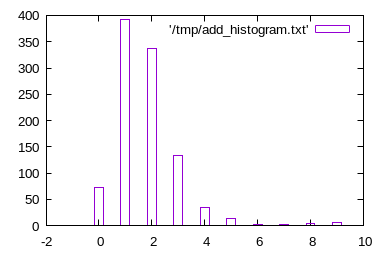

In [ ]:
%%gnuplot
plot '/tmp/add_histogram.txt' with histogram

7. **Caracterización de la latencia**

Según el grafico obtenido, podemos determinar que se trata de una distribución **pareto**.

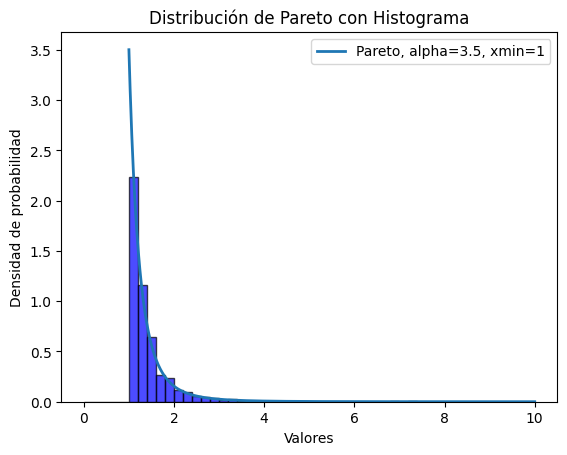

In [ ]:
import numpy as np
from scipy.stats import pareto
import matplotlib.pyplot as plt

# Parámetros de la distribución de Pareto
alpha = 3.5  # Parámetro de forma
xmin = 1      # Valor mínimo

# Distribución de Pareto
pareto_dist = pareto(alpha, scale=xmin)

# Generar datos según la distribución de Pareto
data_pareto = pareto_dist.rvs(size=1000)

# Crear histograma con barras más anchas y espacio entre ellas
plt.hist(data_pareto, bins=np.arange(0, 10, 0.2), density=True, alpha=0.7, color='blue', edgecolor='black', linewidth=1)

# Graficar la distribución de Pareto
x = np.linspace(xmin, 10, 1000)
pareto_pdf = pareto_dist.pdf(x)
plt.plot(x, pareto_pdf, label=f'Pareto, alpha={alpha}, xmin={xmin}', linewidth=2)

# Configurar título y etiquetas
plt.title('Distribución de Pareto con Histograma')
plt.xlabel('Valores')
plt.ylabel('Densidad de probabilidad')
plt.legend()

# Mostrar la gráfica
plt.show()

## **Clasificación de QoE**

### **En tu host:**

Tras ejecutar:

In [ ]:
!python3 ~/Escritorio/NAT/minimal.py

(INFO) minimal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) minimal: NUMBER_OF_CHANNELS = 2
(INFO) minimal: chunk_time = 0.023219954648526078 seconds
(INFO) minimal: Press enter-key to quit
^C

SIGINT received


Podemos determinar que la la comunicación es **Aceptable**. Se notan los efectos de la latencia, además del eco, sin embargo, la comunicación es fluida. Si no establecemos volumenes demasiado altos no se produce ese desabradable sonido donde se acopla el audio.

### **En Internet**

Para obtener la ip y el puerto necesario, ejecutamos:

In [ ]:
import os
os.chdir('/home/javier/Escritorio/NAT')
!python3 NAT_traversal.py

Puerto Externo: 54320, IP Externa: 217.216.183.232, End-Point: 217.216.183.232:54320, Tipo de NAT: Full Cone
Puerto Externo: 54320, IP Externa: 217.216.183.232, End-Point: 217.216.183.232:54320, Tipo de NAT: Full Cone
Puerto Externo: 54320, IP Externa: 217.216.183.232, End-Point: 217.216.183.232:54320, Tipo de NAT: Full Cone
Puerto Externo: 54320, IP Externa: 217.216.183.232, End-Point: 217.216.183.232:54320, Tipo de NAT: Restric NAT
Puerto Externo: 54320, IP Externa: 217.216.183.232, End-Point: 217.216.183.232:54320, Tipo de NAT: Restric NAT
Puerto Externo: 54320, IP Externa: 217.216.183.232, End-Point: 217.216.183.232:54320, Tipo de NAT: Restric NAT
NAT abierto (Full Cone)
Puede establecer conexion con otro dispositivo. Para ello ejecute el siguiente comando: python3 NAT-traversal -l 'puerto de escucha' -a 'ip de destino' -p 'puerto de destino'


Tras esto, intercambiamos datos con otra persona y ejecutamos en ambos dispositivos:

**python3 NAT_traversal.py -l *puerto_de_escucha* -a *ip_de_destino* -p *puerto_de_destino*.**

In [ ]:
import os
os.chdir('/home/javier/Escritorio/NAT')
!python3 NAT_traversal.py -l 54320 -a 85.60.199.122 -p 54320

(INFO) minimal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) minimal: NUMBER_OF_CHANNELS = 2
(INFO) minimal: chunk_time = 0.023219954648526078 seconds
(INFO) NAT_traversal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) minimal: Press enter-key to quit
^C

SIGINT received


Después de producirse la comunicación, podemos determinar que la QoE es **Buena**. Se entiende bien a los interlocutores aunque se produzca eco.

### **En tu host, pero simulando Internet**

1. **Comprobamos la configuración actual**

In [ ]:
!tc qdisc show dev lo

qdisc noqueue 0: root refcnt 2 


2. **Modificamos la configuración para similar la latencia**

In [ ]:
!pkexec tc qdisc add dev lo root netem delay 24ms 10ms 8% distribution normal

3. **Comprobamos el funcionamiento de minimal**

In [ ]:
!python3 ~/Escritorio/NAT/minimal.py

(INFO) minimal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) minimal: NUMBER_OF_CHANNELS = 2
(INFO) minimal: chunk_time = 0.023219954648526078 seconds
(INFO) minimal: Press enter-key to quit
^C

SIGINT received


4. **Eliminamos la regla tc**

In [ ]:
!pkexec tc qdisc delete dev lo root netem delay 24ms 10ms 8% distribution normal

Error: Invalid qdisc name.


5. **Modificamos la regla tc**

In [ ]:
!pkexec tc qdisc change dev lo root netem delay 600ms 10ms 8% distribution normal

In [ ]:
!pkexec tc qdisc delete dev lo root netem delay 600ms 10ms 8% distribution normal

Podemos determinar que la la comunicación es **Aceptable**. Se notan los efectos de la latencia, además del eco, sin embargo, la comunicación es fluida. Si no establecemos volumenes demasiado altos no se produce ese desabradable sonido donde se acopla el audio.

## **Clasificación QoE considerando perdida de paquetes**

1. **Configuramos la perdida de paquetes**

In [ ]:
!pkexec tc qdisc add dev wlp0s20f3 root netem loss 10%

2. **Comprobamos el funcionamiento de minimal**

In [ ]:
import os
os.chdir('/home/javier/Escritorio/NAT')
!python3 NAT_traversal.py -l 54320 -a 85.60.199.122 -p 54320

3. **Eliminamos la configuración**

In [ ]:
!pkexec tc qdisc delete dev wlp0s20f3 root netem loss 10%

Ejecutando los comandos anteriores, podemos determinar que la comunicación con perdida de paquetes es **Regular (Bad)**.

## **Control del tamaño del Buffer en InterCom**

Para saber que tiempo de buffering debemos usar para esconder el jitter hemos realizado una serie de experimentos.

In [ ]:
import os
os.chdir('/home/javier/Escritorio/NAT')
!python3 buffer.py -l 54320 -a 85.60.199.122 -p 54320 -b 10

(INFO) minimal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) minimal: NUMBER_OF_CHANNELS = 2
(INFO) minimal: chunk_time = 0.023219954648526078 seconds
(INFO) buffer: Over minimal, implements a random access buffer structure for hiding the jitter.
(INFO) buffer: buffering_time = 10 miliseconds
(INFO) buffer: chunks_to_buffer = 1
(INFO) buffer: Press CTRL+c to quit
^C

SIGINT received


In [ ]:
import os
os.chdir('/home/javier/Escritorio/NAT')
!python3 buffer.py -l 54320 -a 85.60.199.122 -p 54320 -b 50

In [ ]:
import os
os.chdir('/home/javier/Escritorio/NAT')
!python3 buffer.py -l 54320 -a 85.60.199.122 -p 54320 -b 60

In [ ]:
import os
os.chdir('/home/javier/Escritorio/NAT')
!python3 buffer.py -l 54320 -a 85.60.199.122 -p 54320 -b 80

Tras esto, determinamos que un tiempo de buffering de **60ms** es ideal para que la comunicación sea buena. Sin embargo, **50ms** es el tiempo minimo encontrado donde la comunicación es acceptable y se elimina el problema de jitter.

## **Creación del modulo NAT_Traversal**

Hemos modificado el codigo de **buffer.py** para que herede de NAT_Traversal y no de minimal. El resultado es el siguiente:

In [ ]:
#!/usr/bin/env python
# PYTHON_ARGCOMPLETE_OK

"""Over minimal, implements a random access buffer structure for hiding the jitter."""

import argparse
import sounddevice as sd
import numpy as np
import socket
import time
import psutil
import math
import struct
import threading
import NAT_traversal
import soundfile as sf
import logging

NAT_traversal.minimal.parser.add_argument("-b", "--buffering_time", type=int, default=150, help="Miliseconds to buffer")

class Buffering(NAT_traversal.NAT_Traversal):

    CHUNK_NUMBERS = 1 << 15 # Enought for most buffering times.

    def __init__(self):
        ''' Initializes the buffer. '''
        super().__init__()
        logging.info(__doc__)
        if NAT_traversal.minimal.args.buffering_time <= 0:
            NAT_traversal.minimal.args.buffering_time = 1 # ms
        logging.info(f"buffering_time = {NAT_traversal.minimal.args.buffering_time} miliseconds")
        self.chunks_to_buffer = int(math.ceil(NAT_traversal.minimal.args.buffering_time / 1000 / self.chunk_time))
        self.zero_chunk = self.generate_zero_chunk()
        self.cells_in_buffer = self.chunks_to_buffer * 2
        self._buffer = [None] * self.cells_in_buffer
        for i in range(self.cells_in_buffer):
            self._buffer[i] = self.zero_chunk
        #self.sock.settimeout(self.chunk_time)
        #self.sock.settimeout(0)
        self.chunk_number = 0
        logging.info(f"chunks_to_buffer = {self.chunks_to_buffer}")

        if NAT_traversal.minimal.args.filename:
            logging.info(f"Using \"{NAT_traversal.minimal.args.filename}\" as input")
            self.wavfile = sf.SoundFile(NAT_traversal.minimal.args.filename, 'r')
            self._handler = self._read_io_and_play
            self.stream = self.file_stream
        else:
            self._handler = self._record_io_and_play
            self.stream = self.mic_stream

    def pack(self, chunk_number, chunk):
        '''Concatenates a chunk number to the chunk.'''
        packed_chunk = struct.pack("!H", chunk_number) + chunk.tobytes()
        return packed_chunk

    def unpack(self, packed_chunk):
        '''Splits the packed chunk into a chunk number and a chunk.'''
        (chunk_number,) = struct.unpack("!H", packed_chunk[:2])
        chunk = packed_chunk[2:]
        # Notice that struct.calcsize('H') = 2
        chunk = np.frombuffer(chunk, dtype=np.int16)
        #chunk = chunk.reshape(minimal.args.frames_per_chunk, self.NUMBER_OF_CHANNELS)
        return chunk_number, chunk

    def buffer_chunk(self, chunk_number, chunk):
        self._buffer[chunk_number % self.cells_in_buffer] = chunk

    def unbuffer_next_chunk(self):
        chunk = self._buffer[self.played_chunk_number % self.cells_in_buffer]
        return chunk

    def play_chunk(self, DAC, chunk):
        self.played_chunk_number = (self.played_chunk_number + 1) % self.cells_in_buffer
        chunk = chunk.reshape(NAT_traversal.minimal.args.frames_per_chunk, self.NUMBER_OF_CHANNELS)
        DAC[:] = chunk

    def receive(self):
        packed_chunk, sender = self.sock.recvfrom(self.MAX_PAYLOAD_BYTES)
        return packed_chunk

    def receive_and_buffer(self):
        if __debug__:
            print(next(NAT_traversal.minimal.spinner), end='\b', flush=True)
        packed_chunk = self.receive()
        chunk_number, chunk = self.unpack(packed_chunk)
        self.buffer_chunk(chunk_number, chunk)
        return chunk_number

    def _record_io_and_play(self, indata, outdata, frames, time, status):
        self.chunk_number = (self.chunk_number + 1) % self.CHUNK_NUMBERS
        packed_chunk = self.pack(self.chunk_number, indata)
        self.send(packed_chunk)
        chunk = self.unbuffer_next_chunk()
        self.play_chunk(outdata, chunk)

    def _read_io_and_play(self, outdata, frames, time, status):
        self.chunk_number = (self.chunk_number + 1) % self.CHUNK_NUMBERS
        read_chunk = self.read_chunk_from_file()
        packed_chunk = self.pack(self.chunk_number, read_chunk)
        self.send(packed_chunk)
        chunk = self.unbuffer_next_chunk()
        self.play_chunk(outdata, chunk)
        return read_chunk

    def run(self):
        '''Creates the stream, install the callback function, and waits for
        an enter-key pressing.'''
        logging.info("Press CTRL+c to quit")
        self.played_chunk_number = 0
        with self.stream(self._handler):
            first_received_chunk_number = self.receive_and_buffer()
            logging.debug("first_received_chunk_number =", first_received_chunk_number)

            self.played_chunk_number = (first_received_chunk_number - self.chunks_to_buffer) % self.cells_in_buffer
            # The previous selects the first chunk to be played the
            # one (probably empty) that are in the buffer
            # <self.chunks_to_buffer> position before
                # <first_received_chunk_number>.

            while True:# and not self.input_exhausted:
                self.receive_and_buffer()

class Buffering__verbose(Buffering, NAT_traversal.minimal.Minimal__verbose):

    def __init__(self):
        super().__init__()

        thread = threading.Thread(target=self.feedback)
        thread.daemon = True # To obey CTRL+C interruption.
        thread.start()

    def feedback(self):
        while True:
            time.sleep(self.seconds_per_cycle)
            self.cycle_feedback()

    def send(self, packed_chunk):
        '''Computes the number of sent bytes and the number of sent
        packets.'''
        Buffering.send(self, packed_chunk)
        self.sent_bytes_count += len(packed_chunk)
        self.sent_messages_count += 1

    def receive(self):
        '''Computes the number of received bytes and the number of received
        packets.'''
        packed_chunk = Buffering.receive(self)
        self.received_bytes_count += len(packed_chunk)
        self.received_messages_count += 1
        return packed_chunk

    def _record_io_and_play(self, indata, outdata, frames, time, status):
        if NAT_traversal.minimal.args.show_samples:
            self.show_indata(indata)

        super()._record_io_and_play(indata, outdata, frames, time, status)

        if NAT_traversal.minimal.args.show_samples:
            self.show_outdata(outdata)

    def _read_io_and_play(self, outdata, frames, time, status):
        if NAT_traversal.minimal.args.show_samples:
            self.show_indata(indata) # OJO, indata undefined

        read_chunk = super()._read_io_and_play(outdata, frames, time, status)

        if NAT_traversal.minimal.args.show_samples:
            self.show_outdata(outdata)
        return read_chunk

    def run(self):
        '''Run the verbose Buffering.'''
        self.print_running_info()
        super().print_header()
        #try:
        self.played_chunk_number = 0
        with self.stream(self._handler):
            first_received_chunk_number = self.receive_and_buffer()
            if __debug__:
                print("first_received_chunk_number =", first_received_chunk_number)
            self.played_chunk_number = (first_received_chunk_number - self.chunks_to_buffer) % self.cells_in_buffer
            while self.total_number_of_sent_chunks < self.chunks_to_sent:# and not self.input_exhausted:
                self.receive_and_buffer()
            #self.print_final_averages()
       # except KeyboardInterrupt:
       #     self.print_final_averages()

try:
    import argcomplete  # <tab> completion for argparse.
except ImportError:
    logging.warning("Unable to import argcomplete (optional)")

if __name__ == "__main__":
    NAT_traversal.minimal.parser.description = __doc__

    try:
        argcomplete.autocomplete(NAT_traversal.minimal.parser)
    except Exception:
        logging.warning("argcomplete not working :-/")

    NAT_traversal.minimal.args = NAT_traversal.minimal.parser.parse_known_args()[0]

    if NAT_traversal.minimal.args.list_devices:
        print("Available devices:")
        print(sd.query_devices())
        quit()

    if NAT_traversal.minimal.args.show_stats or NAT_traversal.minimal.args.show_samples:
        intercom = Buffering__verbose()
    else:
        intercom = Buffering()
    try:
        intercom.run()
    except KeyboardInterrupt:
        NAT_traversal.minimal.parser.exit("\nSIGINT received")
    finally:
        intercom.print_final_averages()


Para ejecutarlo usamos:

In [ ]:
import os
os.chdir('/home/javier/Escritorio/NAT')
!python3 buffer.py

(INFO) minimal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) minimal: NUMBER_OF_CHANNELS = 2
(INFO) minimal: chunk_time = 0.023219954648526078 seconds
(INFO) NAT_traversal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) buffer: Over minimal, implements a random access buffer structure for hiding the jitter.
(INFO) buffer: buffering_time = 150 miliseconds
(INFO) buffer: chunks_to_buffer = 7
(INFO) buffer: Press CTRL+c to quit
^C

SIGINT received


Para comprobar la comunicación entre dos dispositivos ejecutamos:

In [ ]:
import os
os.chdir('/home/javier/Escritorio/NAT')
!python3 buffer.py -l 54320 -a 85.60.199.122 -p 54320 -b 60

(INFO) minimal: A minimal InterCom (no compression, no quantization, no transform, ... only provides a bidirectional (full-duplex) transmission of raw (playable) chunks. 
(INFO) minimal: NUMBER_OF_CHANNELS = 2
(INFO) minimal: chunk_time = 0.023219954648526078 seconds
(INFO) buffer: Over minimal, implements a random access buffer structure for hiding the jitter.
(INFO) buffer: buffering_time = 60 miliseconds
(INFO) buffer: chunks_to_buffer = 3
(INFO) buffer: Press CTRL+c to quit
^C

SIGINT received


## **`Integrantes del grupo`**

- Antonio José Sanchez Carrión
- Daryna Morales Poklad
- Mónica del Pilar Rispal Rodríguez
- Javier Cano González